## Note: All had 5 000 Epochs expect for the 0.01 which had only 600 Epochs

In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib
import matplotlib.pyplot as plt


In [3]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


In [4]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=[
    'model_name', 'total', 'delta', 'avg_abs_error', 'avg_abs_error_denorm',
    'median_abs_error', 'median_abs_error_denorm', 'mean_square_error', 'mean_square_error_denorm',
    'avg_pct_error', 'std_pct_error', 'avg_pct_error_wo_top_2', 'std_pct_error_wo_top_2',
    'avg_pct_error_denorm', 'std_pct_error_denorm', 'avg_pct_error_wo_top_2_denorm', 
    'std_pct_error_wo_top_2_denorm', 'median_pct_error', 'median_pct_error_denorm',
    'corr_coefficient', 'corr_coefficient_wo_outliers'
])

# Iterate over each file in the directory ../model/models
for filename in os.listdir('../model/models'):
    model_name = filename[14:-3]

    if 'complex' in model_name or not filename.endswith('.pt'):
        continue

    x, y = model_name.split('_')
    total = float(x[:-1])
    delta = float(y[:-1])

    # Load the weights from this file
    model = torch.load(f'../model/models/{filename}')
    data_tensors = torch.load(f'../model/data/data_tensors_{model_name}.pt')
    target_tensors = torch.load(f'../model/data/target_tensors_{model_name}.pt')

    # Normalize the target tensors
    target_mean = target_tensors.mean()
    target_std = target_tensors.std()

    def denormalize(tensor):
        return tensor * target_std + target_mean

    target_tensors = (target_tensors - target_mean) / target_tensors.std()
    train_data, test_data, train_targets, test_targets = train_test_split(
        data_tensors, target_tensors, test_size=0.2, random_state=42
    )

    train_dataset = PacketCaptureDataset(train_data, train_targets)
    test_dataset = PacketCaptureDataset(test_data, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    input_size = len(train_dataset[0][0][0])
    hidden_size = 64
    output_size = 1
    model = RNNModel(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.load_state_dict(torch.load(f'../model/models/model_weights_{model_name}.pt'))

    num_samples = len(test_targets)

    # Initialize lists to store errors
    abs_errors = []
    abs_errors_denorm = []
    pct_errors = []
    pct_errors_denorm = []
    actual_values = []
    predicted_values = []

    # Iterate through the test set
    for i in range(num_samples):
        predicted_value = model(test_data[i].unsqueeze(0)).item()
        actual_value = test_targets[i].item()
        denorm_predicted_value = denormalize(predicted_value)
        denorm_actual_value = denormalize(actual_value)

        abs_error = abs(predicted_value - actual_value)
        abs_error_denorm = abs(denorm_predicted_value - denorm_actual_value)
        pct_error = abs_error / abs(actual_value)
        pct_error_denorm = abs_error_denorm / abs(denorm_actual_value)

        abs_errors.append(abs_error)
        abs_errors_denorm.append(abs_error_denorm)
        pct_errors.append(pct_error)
        pct_errors_denorm.append(pct_error_denorm)
        actual_values.append(denorm_actual_value)
        predicted_values.append(denorm_predicted_value)

    # Calculate metrics
    avg_abs_error = np.mean(abs_errors)
    avg_abs_error_denorm = np.mean(abs_errors_denorm)
    median_abs_error = np.median(abs_errors)
    median_abs_error_denorm = np.median(abs_errors_denorm)
    mean_square_error = np.mean(np.square(abs_errors))
    mean_square_error_denorm = np.mean(np.square(abs_errors_denorm))
    avg_pct_error = np.mean(pct_errors) * 100
    std_pct_error = np.std(pct_errors)
    avg_pct_error_denorm = np.mean(pct_errors_denorm) * 100
    std_pct_error_denorm = np.std(pct_errors_denorm)

    # Remove top 2% errors for percentage calculations
    num_samples_to_remove = int(num_samples * 0.02)
    sorted_abs_errors = sorted(abs_errors)[:-num_samples_to_remove]
    sorted_pct_errors = sorted(pct_errors)[:-num_samples_to_remove]
    sorted_abs_errors_denorm = sorted(abs_errors_denorm)[:-num_samples_to_remove]
    sorted_pct_errors_denorm = sorted(pct_errors_denorm)[:-num_samples_to_remove]

    avg_pct_error_wo_top_2 = (np.sum(sorted_abs_errors) / len(sorted_abs_errors)) / target_mean * 100
    std_pct_error_wo_top_2 = np.std(sorted_pct_errors)
    avg_pct_error_wo_top_2_denorm = (np.sum(sorted_abs_errors_denorm) / len(sorted_abs_errors_denorm)) / target_mean * 100
    std_pct_error_wo_top_2_denorm = np.std(sorted_pct_errors_denorm)

    median_pct_error = np.median(pct_errors) * 100
    median_pct_error_denorm = np.median(pct_errors_denorm) * 100

    actual_values_np = np.array(actual_values)
    predicted_values_np = np.array(predicted_values)
    corr_coefficient = np.corrcoef(actual_values_np, predicted_values_np)[0, 1]

    # Remove outliers based on absolute errors
    abs_errors_np = np.array(abs_errors_denorm)
    error_threshold = np.percentile(abs_errors_np, 98)  # Define threshold to exclude top 2% errors
    mask = abs_errors_np <= error_threshold

    actual_values_wo_outliers = actual_values_np[mask]
    predicted_values_wo_outliers = predicted_values_np[mask]
    corr_coefficient_wo_outliers = np.corrcoef(actual_values_wo_outliers, predicted_values_wo_outliers)[0, 1]

    # Append the results to the DataFrame
    results_df = results_df.append({
        'model_name': model_name, 'total': total, 'delta': delta, 
        'avg_abs_error': avg_abs_error, 'avg_abs_error_denorm': avg_abs_error_denorm,
        'median_abs_error': median_abs_error, 'median_abs_error_denorm': median_abs_error_denorm,
        'mean_square_error': mean_square_error, 'mean_square_error_denorm': mean_square_error_denorm,
        'avg_pct_error': avg_pct_error, 'std_pct_error': std_pct_error,
        'avg_pct_error_wo_top_2': avg_pct_error_wo_top_2, 'std_pct_error_wo_top_2': std_pct_error_wo_top_2,
        'avg_pct_error_denorm': avg_pct_error_denorm, 'std_pct_error_denorm': std_pct_error_denorm,
        'avg_pct_error_wo_top_2_denorm': avg_pct_error_wo_top_2_denorm, 'std_pct_error_wo_top_2_denorm': std_pct_error_wo_top_2_denorm,
        'median_pct_error': median_pct_error, 'median_pct_error_denorm': median_pct_error_denorm,
        'corr_coefficient': corr_coefficient, 'corr_coefficient_wo_outliers': corr_coefficient_wo_outliers
    }, ignore_index=True)

# Save the results to a CSV file if needed
results_df.to_csv('model_evaluation_results.csv', index=False)

/tmp/ipykernel_16034/961870961.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_16034/961870961.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_16034/961870961.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_16034/961870961.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_16034/961870961.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [5]:
print(results_df)

  model_name  total  delta  avg_abs_error  avg_abs_error_denorm  \
0     10s_1s   10.0   1.00       0.268586             30.355574   
1     10s_5s   10.0   5.00       0.393372             44.432957   
2   15s_0.2s   15.0   0.20      32.192667           3633.275391   
3  15s_0.05s   15.0   0.05      28.620510           3230.274902   
4  10s_0.05s   10.0   0.05       0.216105             24.423410   
5   10s_0.2s   10.0   0.20       0.231012             26.101227   
6  10s_0.01s   10.0   0.01       0.222148             25.106943   

   median_abs_error  median_abs_error_denorm  mean_square_error  \
0          0.064596                 7.300698           0.713853   
1          0.210245                23.748058           1.316353   
2          5.553298               626.747192       19069.946038   
3          5.622117               634.544434        9521.940936   
4          0.017247                 1.949247           1.078340   
5          0.026362                 2.978510           0.7421

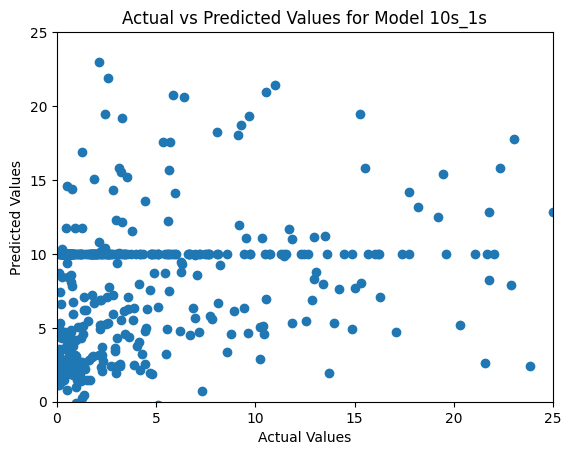

Model: 10s_1s
Correlation Coefficient: 0.5390517541043943
Correlation Coefficient without Outliers: 0.7052086772711831



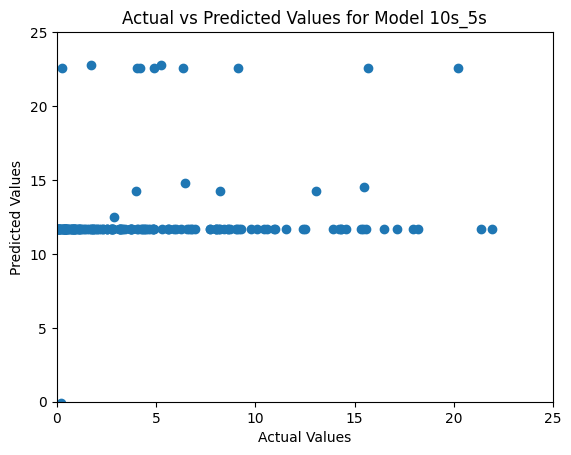

Model: 10s_5s
Correlation Coefficient: 0.04982960609708067
Correlation Coefficient without Outliers: 0.2296877115762804



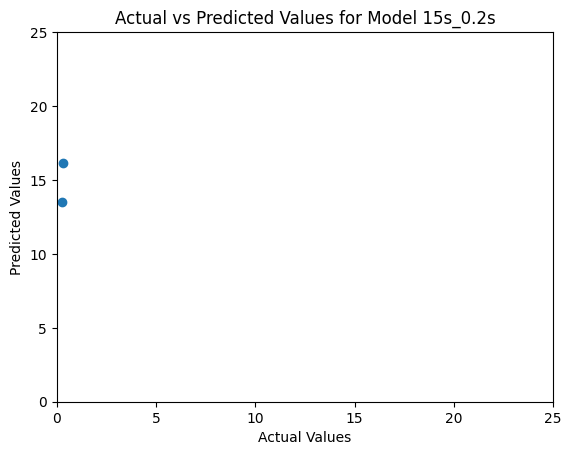

Model: 15s_0.2s
Correlation Coefficient: 0.286100954745133
Correlation Coefficient without Outliers: 0.5618344377510611



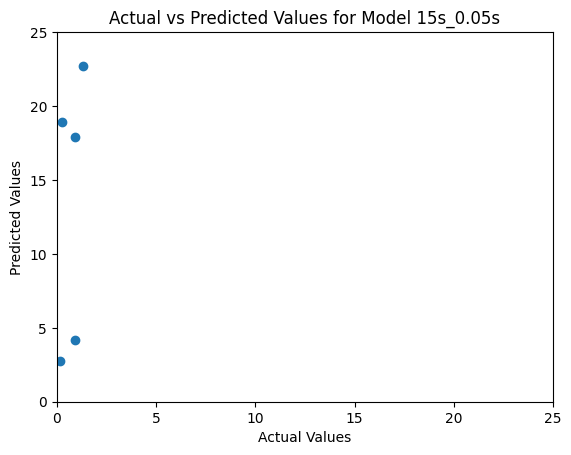

Model: 15s_0.05s
Correlation Coefficient: 0.5438862358645805
Correlation Coefficient without Outliers: 0.5092399937632535



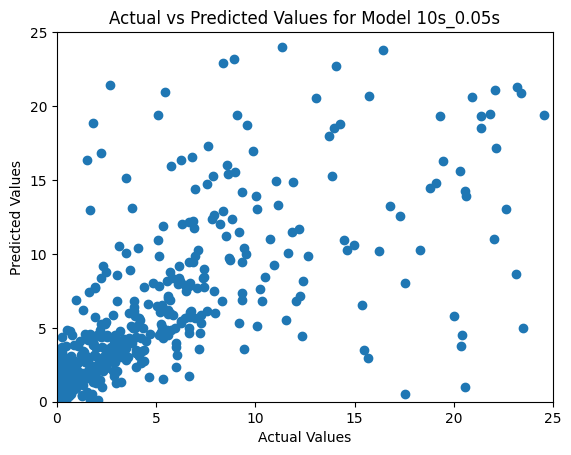

Model: 10s_0.05s
Correlation Coefficient: 0.4304670871837377
Correlation Coefficient without Outliers: 0.6138160254610361



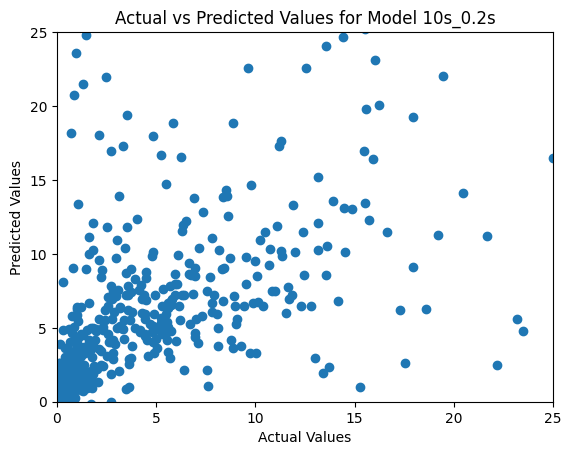

Model: 10s_0.2s
Correlation Coefficient: 0.5479387545880439
Correlation Coefficient without Outliers: 0.5800628965438456



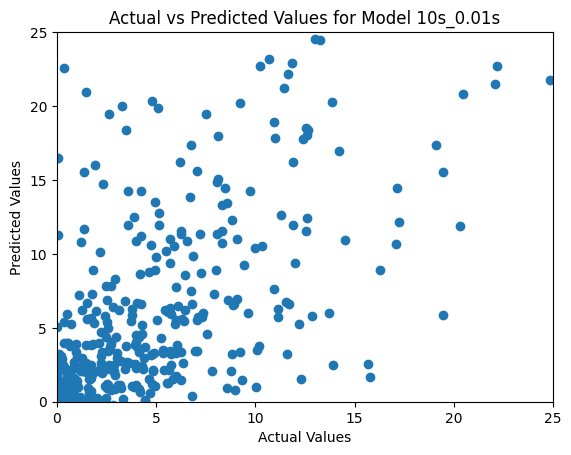

Model: 10s_0.01s
Correlation Coefficient: 0.44845423970632764
Correlation Coefficient without Outliers: 0.7865354781600754



In [6]:
# for each model, plot the actual vs predicted values followed by printing the correlation coefficient and the correlation coefficient without outliers

for filename in os.listdir('../model/models'):
    model_name = filename[14:-3]

    if 'complex' in model_name or not filename.endswith('.pt'):
        continue

    x, y = model_name.split('_')
    total = float(x[:-1])
    delta = float(y[:-1])

    # Load the weights from this file
    model = torch.load(f'../model/models/{filename}')
    data_tensors = torch.load(f'../model/data/data_tensors_{model_name}.pt')
    target_tensors = torch.load(f'../model/data/target_tensors_{model_name}.pt')

    # Normalize the target tensors
    target_mean = target_tensors.mean()
    target_std = target_tensors.std()

    def denormalize(tensor):
        return tensor * target_std + target_mean

    target_tensors = (target_tensors - target_mean) / target_tensors.std()
    train_data, test_data, train_targets, test_targets = train_test_split(
        data_tensors, target_tensors, test_size=0.2, random_state=42
    )

    train_dataset = PacketCaptureDataset(train_data, train_targets)
    test_dataset = PacketCaptureDataset(test_data, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    input_size = len(train_dataset[0][0][0])
    hidden_size = 64
    output_size = 1
    model = RNNModel(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.load_state_dict(torch.load(f'../model/models/model_weights_{model_name}.pt'))

    num_samples = len(test_targets)

    # Initialize lists to store errors
    abs_errors = []
    abs_errors_denorm = []
    pct_errors = []
    pct_errors_denorm = []
    actual_values = []
    predicted_values = []

    # Iterate through the test set
    for i in range(num_samples):
        predicted_value = model(test_data[i].unsqueeze(0)).item()
        actual_value = test_targets[i].item()
        denorm_predicted_value = denormalize(predicted_value)
        denorm_actual_value = denormalize(actual_value)

        abs_error = abs(predicted_value - actual_value)
        abs_error_denorm = abs(denorm_predicted_value - denorm_actual_value)
        pct_error = abs_error / abs(actual_value)
        pct_error_denorm = abs_error_denorm / abs(denorm_actual_value)

        abs_errors.append(abs_error)
        abs_errors_denorm.append(abs_error_denorm)
        pct_errors.append(pct_error)
        pct_errors_denorm.append(pct_error_denorm)
        actual_values.append(denorm_actual_value)
        predicted_values.append(denorm_predicted_value)

    # Calculate metrics
    avg_abs_error = np.mean(abs_errors)
    avg_abs_error_denorm = np.mean(abs_errors_denorm)
    median_abs_error = np.median(abs_errors)
    median_abs_error_denorm = np.median(abs_errors_denorm)
    mean_square_error = np.mean(np.square(abs_errors))
    mean_square_error_denorm = np.mean(np.square(abs_errors_denorm))
    avg_pct_error = np.mean(pct_errors) * 100
    std_pct_error = np.std(pct_errors)
    avg_pct_error_denorm = np.mean(pct_errors_denorm) * 100
    std_pct_error_denorm = np.std(pct_errors_denorm)
    
    # Remove top 2% errors for percentage calculations
    num_samples_to_remove = int(num_samples * 0.02)
    sorted_abs_errors = sorted(abs_errors)[:-num_samples_to_remove]
    sorted_pct_errors = sorted(pct_errors)[:-num_samples_to_remove]
    sorted_abs_errors_denorm = sorted(abs_errors_denorm)[:-num_samples_to_remove]
    sorted_pct_errors_denorm = sorted(pct_errors_denorm)[:-num_samples_to_remove]

    avg_pct_error_wo_top_2 = (np.sum(sorted_abs_errors) / len(sorted_abs_errors)) / target_mean * 100
    std_pct_error_wo_top_2 = np.std(sorted_pct_errors)
    avg_pct_error_wo_top_2_denorm = (np.sum(sorted_abs_errors_denorm) / len(sorted_abs_errors_denorm)) / target_mean * 100
    std_pct_error_wo_top_2_denorm = np.std(sorted_pct_errors_denorm)
    
    actual_values_np = np.array(actual_values)
    predicted_values_np = np.array(predicted_values)
    corr_coefficient = np.corrcoef(actual_values_np, predicted_values_np)[0, 1]

    # Remove outliers based on absolute errors
    abs_errors_np = np.array(abs_errors_denorm)
    error_threshold = np.percentile(abs_errors_np, 98)  # Define threshold to exclude top 2% errors
    mask = abs_errors_np <= error_threshold

    actual_values_wo_outliers = actual_values_np[mask]
    predicted_values_wo_outliers = predicted_values_np[mask]
    corr_coefficient_wo_outliers = np.corrcoef(actual_values_wo_outliers, predicted_values_wo_outliers)[0, 1]

    # Plot the actual vs predicted values
    plt.scatter(actual_values, predicted_values)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for Model {model_name}')
    # make the window 200 by 200
    plt.xlim(0, 25)
    plt.ylim(0, 25)
    plt.show()

    print(f'Model: {model_name}')
    print(f'Correlation Coefficient: {corr_coefficient}')
    print(f'Correlation Coefficient without Outliers: {corr_coefficient_wo_outliers}')
    print()
